# scRNA-seq Analysis Pipeline

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#scRNA-seq-Analysis-Pipeline" data-toc-modified-id="scRNA-seq-Analysis-Pipeline-1"><span class="toc-item-num"></span>scRNA-seq Analysis Pipeline</a></span></li><li><span>
<a href="#1.-Load-datasets" data-toc-modified-id="1.-Load-datasets-2"><span class="toc-item-num"></span>1. Load datasets</a></span></li><li><span>
<a href="#2.-Filter-Out-Genes-with-QC" data-toc-modified-id="2.-Filter-Out-Genes-with-QC-3"><span class="toc-item-num"></span>2. Filter Out Genes with QC</a></span></li><li><span>
<a href="#3.-Library-Size-Analysis" data-toc-modified-id="3.-Library-Size-Analysis-4"><span class="toc-item-num"></span>3. Library Size Analysis</a></span></li><li><span>
<a href="#4.-Normalization" data-toc-modified-id="4.-Normalization-5"><span class="toc-item-num"></span>4. Normalization</a></span></li><li><span>
<a href="#5.-Most-Highly-Expressed-Genes" data-toc-modified-id="5.-Most-Highly-Expressed-Genes-6"><span class="toc-item-num"></span>5. Most Highly Expressed Genes</a></span></li><li><span>
<a href="#6.-Plot-the-Samples" data-toc-modified-id="6.-Plot-the-Samples-7"><span class="toc-item-num"></span>6. Plot the Samples</a></span></li><li><span>
<a href="#7.-MAGIC" data-toc-modified-id="7.-MAGIC-8"><span class="toc-item-num"></span>7. MAGIC</a></span></li><li><span>
<a href="#8.-Clustergrammer" data-toc-modified-id="8.-Clustergrammer-9"><span class="toc-item-num"></span>8. Clustergrammer</a></span></li><li><span>
<a href="#9.-Differential-Gene-Expression" data-toc-modified-id="9.-Differential-Gene-Expression-10"><span class="toc-item-num"></span>9. Differential Gene Expression</a></span></li><li><span>
<a href="#10.-Clustering" data-toc-modified-id="10.-Clustering-11"><span class="toc-item-num"></span>10. Clustering</a></span></li><li><span>
<a href="#11.-Trajectory-Inference" data-toc-modified-id="11.-Trajectory-Inference-12"><span class="toc-item-num"></span>11. Trajectory Inference</a></span></li><li><span>
<a href="#12.-Time-series-Trajectory-Analysis" data-toc-modified-id="12.-Time-series-Trajectory-Analysis-13"><span class="toc-item-num"></span>12. Time-series Trajectory Analysis</a></span></li><li><span>
<a href="#13.-Enrichment-Analysis" data-toc-modified-id="13.-Enrichment-Analysis-14"><span class="toc-item-num"></span>13. Enrichment Analysis</a></span></li><li><span>
<a href="#14.-Gene-Ontology-Enrichment-Analysis" data-toc-modified-id="14.-Gene-Ontology-Enrichment-Analysis-15"><span class="toc-item-num"></span>14. Gene Ontology Enrichment Analysis</a></span></li><li><span>
<a href="#15.-Cell-Type-Prediction-with-DigitalCellSorter" data-toc-modified-id="15.-Cell-Type-Prediction-with-DigitalCellSorter-16"><span class="toc-item-num"></span>15. Cell Type Prediction with DigitalCellSorter</a></span></li><li><span>
<a href="#References" data-toc-modified-id="References-17"><span class="toc-item-num"></span>References</a></span></li></ul></div>

In [288]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [289]:
%%javascript
require.config({
  paths: {
    d3: 'https://cdnjs.cloudflare.com/ajax/libs/d3/5.9.2/d3',
    jquery: 'https://code.jquery.com/jquery-3.4.1.min',
    plotly: 'https://cdn.plot.ly/plotly-latest.min'
  },

  shim: {
    plotly: {
      deps: ['d3', 'jquery'],
      exports: 'plotly'
    }
  }
});

<IPython.core.display.Javascript object>

In [290]:
%%appyter hide_code
{% do SectionField(
    name='PRIMARY',
    title='Single cell RNA-seq analysis pipeline',
    subtitle='This pipeline enables you to analyze and visualize your single cell RNA sequencing datasets with an array of algorithms and data visualization methods. The pipeline includes quality control, library size analysis, normalization, plotting most highly expressed genes, plotting samples, MAGIC normalization, clustering, enrichment analysis, trajectory inference, and cell type prediction.',
    img='analysis.png'
) %}

In [291]:
%%appyter code_exec
meta_data_filename = "{{ FileField(name='meta_data_filename', label='Meta data file (.csv or .tsv)', default='GSE110499_example_metadata.txt',
    examples={'GSE110499_example_metadata.txt': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/GSE110499-metadata.txt'}, description='Upload metadata as two-column csv format. The first column contains sample IDs and the other column contains sample labels', section='PRIMARY').value }}"
rnaseq_data_filename = "{{ FileField(name='rnaseq_data_filename', label='RNA-seq data file (.csv or .tsv)', default='GSE110499_example_expression.txt',
    examples={'GSE110499_example_expression.txt': 'https://appyters.maayanlab.cloud/storage/SC_RNA_seq/GSE110499-expression.txt'}, description='Upload RNA-seq dataset as csv format. The index of the dataset are genes, the columns are samples.', section='PRIMARY').value }}"

meta_class_column_name = "{{ StringField(name='meta_class_column_name', label='Class column name in metadata', default='prep-site', description='class column name of metadata', section='PRIMARY').value }}"
meta_id_column_name = "{{ StringField(name='meta_id_column_name', label='Sample ID column name in metadata', default='Sample_geo_accession', description='sample ID column name of metadata', section='PRIMARY').value }}"

qc_filter_genes = {{ BoolField(name='qc_filter_genes', label='Filter genes by quality control?', default='true', description='Check if you want cells to be filtered by quality control', section='PRIMARY').value }}
qc_threshold = {{ FloatField(name='qc_threshold', label='Mitochondria Quality Control threshold', default='0.05', description='Remove cells that have too many mitochondrial genes expressed.', section='PRIMARY').value }}
log_normalization = {{ BoolField(name='log_normalization', label='Log normalization?', default='true', description='Check if you want the dataset to be log-transformed', section='PRIMARY').value }}
normalization_method = "{{ ChoiceField(name='normalization_method',label='Normalization',choices={'Satija et al. (2015, Nature Biotechnology)': 'Seurat', 'Zheng et al. (2017, Nature Communications)': 'Zheng17','Weinreb et al. (2018, PNAS)': 'Weignreb17'},default='Satija et al. (2015, Nature Biotechnology)', description='Standard normlization recipe for scRNA-seq datasets', section='PRIMARY').value }}"
highest_expr_n_genes = {{ IntField(name='highest_expr_n_genes', label='Genes for highest expression', min=0, max=100, default=10, description='The number of genes with highest expression values', section='PRIMARY').value }}
gene_list_for_clustergrammer = {{ TextField(name='gene_list_for_clustergrammer', label='Gene List for Clustergrammer (Optional)', default='', description='Paste your gene list (One gene per row) for Clustergrammer heatmap plots.', section = 'PRIMARY') }}
dim_reduction_method = "{{ ChoiceField(name='dim_reduction_method',label='Method for dimension reduction',choices={'PCA': 'PCA','t-SNE': 't-SNE', 'UMAP': 'UMAP'},default='PCA', description='Dimension reduction methods', section='PRIMARY').value }}"
nr_genes = {{ IntField(name='nr_genes', label='Genes for dimension reduction', min=0, max=30000, default=500, description='The maximum number of genes for dimension reduction analysis', section='PRIMARY').value }}
trajectory_method = "{{ ChoiceField(name='trajectory_method',label='Trajectory inference method',choices={'DPT(diffusion pseudotime)': 'dpt', 'monocle': 'monocle'},default='DPT(diffusion pseudotime)', description='Trajectory inference algorithm', section='PRIMARY').value }}"
enrichment_groupby = "{{ ChoiceField(name='enrichment_groupby',label='Group for enrichment analysis',choices={'cluster': 'cluster', 'cell type': 'cell_type'},default='cluster', description='Specify groups for enrichment analysis', section='PRIMARY').value }}"
nr_genesets = {{ IntField(name='nr_genesets', label='Top ranked gene sets', min=0, max=100,default=15, description='the number of result gene sets', section='PRIMARY').value }}

time_series_trajectory = {{ BoolField(name='time_series_trajectory', label='Time series trajectory analysis?', default='false', description='Check if you want time-series trajectory analysis', section='PRIMARY').value }}
timepoint_labels_column_name = "{{ StringField(name='timepoint_labels_column_name', label='Timepoint column name in metadata', default='Timepoints', description='Timepoint column name of metadata', section='PRIMARY').value }}"
timepoint_labels = {{ TextField(name='timepoint_labels', label='Ordered timepoint labels in the timepoint label column', default='', description='Paste your timepoint labels in order (One timepoint per row). e.g., 0H, 12H, 24H', section = 'PRIMARY') }}

interactive_plot = {{ BoolField(name='interactive_plot', label='Interactive plots?', default='true', description='Check if you want interactive plots', section='PRIMARY').value }}

```python
meta_data_filename = "GSE116500-metadata.txt.txt"
rnaseq_data_filename = "GSE116500-expression.txt.txt"
meta_class_column_name = "donor gender"
meta_id_column_name = "Sample_geo_accession"
qc_filter_genes = True
qc_threshold = 0.05
log_normalization = True
normalization_method = "Seurat"
highest_expr_n_genes = 10
gene_list_for_clustergrammer = ''''''
dim_reduction_method = "PCA"
nr_genes = 500
trajectory_method = "dpt"
enrichment_groupby = "cluster"
nr_genesets = 15
time_series_trajectory = False
timepoint_labels_column_name = "Timepoints"
timepoint_labels = ''''''
interactive_plot = True
```

In [340]:
import pandas as pd
import os
import urllib3
import requests, json
import sys
import math
import geode

import seaborn as sns
import scipy.stats as ss

import plotly
from plotly import tools
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib_venn import venn2, venn3

import IPython
from IPython.display import HTML, display, Markdown, IFrame, FileLink
from itertools import combinations
import base64  
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import quantile_transform
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import umap

from collections import OrderedDict
import random
from time import sleep
import time
import operator
import numpy as np

import warnings

from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
from magic import MAGIC
import chart_studio
import chart_studio.plotly as py

import scanpy as sc
import anndata
import DigitalCellSorter
import shutil
from datetime import datetime


warnings.filterwarnings('ignore')
random.seed(0)
chart_studio.tools.set_credentials_file(username='mjjeon', api_key='v0rpMa6lhST28Sq7XqtM')
pandas2ri.activate()
if interactive_plot == True:
    plot_type='interactive'
else:
    plot_type='static'
results = {}

In [294]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

# 1. Load datasets

In [295]:
if rnaseq_data_filename.endswith(".h5"):
    adata = anndata.read_hdf(rnaseq_data_filename, 'matrix')
else:
    if rnaseq_data_filename.endswith(".csv"):
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0).sort_index()
    else:
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
    if meta_data_filename.endswith(".csv"):
        meta_df = pd.read_csv(meta_data_filename, index_col=0)
    else:
        meta_df = pd.read_csv(meta_data_filename, index_col=0, sep="\t")

    # Match samples between the metadata and the datasets
    meta_df = meta_df.loc[expr_df.columns, :]
    expr_df = expr_df.loc[:,meta_df.index]

    # convert df into anndata
    adata = anndata.AnnData(expr_df.T, obs = pd.DataFrame(meta_df[meta_class_column_name]))
    adata.X = adata.X.astype('float64')

    assert(meta_df.shape[0]==expr_df.shape[1])
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Display datasets

In [296]:
display(adata.to_df().head())

1-Dec  1-Mar  1-Mar-1  1-Sep  10-Mar  10-Sep  \
CL11L_V1_AAACATACGGCATT-1    0.0    0.0      0.0    0.0     0.0     0.0   
CL11L_V1_AAACATTGAAGGGC-1    0.0    0.0      0.0    0.0     0.0     0.0   
CL11L_V1_AAACATTGTGAGCT-1    0.0    0.0      0.0    0.0     0.0     0.0   
CL11L_V1_AAACCGTGGGAACG-1    0.0    0.0      0.0    0.0     0.0     0.0   
CL11L_V1_AAACGCACCGAGTT-1    0.0    0.0      0.0    0.0     0.0     0.0   

                           11-Mar  11-Sep  12-Sep  14-Sep  ...  ZZEF1  ZZZ3  \
CL11L_V1_AAACATACGGCATT-1     0.0     0.0     0.0     0.0  ...    0.0   0.0   
CL11L_V1_AAACATTGAAGGGC-1     0.0     0.0     0.0     0.0  ...    1.0   0.0   
CL11L_V1_AAACATTGTGAGCT-1     0.0     0.0     0.0     0.0  ...    0.0   0.0   
CL11L_V1_AAACCGTGGGAACG-1     0.0     0.0     0.0     0.0  ...    0.0   0.0   
CL11L_V1_AAACGCACCGAGTT-1     0.0     0.0     0.0     0.0  ...    0.0   0.0   

                           hsa-mir-1199  hsa-mir-1253  hsa-mir-150  \
CL11L_V1_AAACATACGGCATT-1           0.0           0.0          0.0   
CL11L_V1_AAACATTGAAGGGC-1           0.0           0.0          0.0   
CL11L_V1_AAACATTGTGAGCT-1           0.0           0.0          0.0   
CL11L_V1_AAACCGTGGGAACG-1           0.0           0.0          0.0   
CL11L_V1_AAACGCACCGAGTT-1           0.0           0.0          0.0   

                           hsa-mir-335  hsa-mir-490  hsa-mir-7515  \
CL11L_V1_AAACATACGGCATT-1          0.0          0.0           0.0   
CL11L_V1_AAACATTGAAGGGC-1          0.0          0.0           0.0   
CL11L_V1_AAACATTGTGAGCT-1          0.0          0.0           0.0   
CL11L_V1_AAACCGTGGGAACG-1          0.0          0.0           0.0   
CL11L_V1_AAACGCACCGAGTT-1          0.0          0.0           0.0   

                           hsa-mir-8072  snoU13  
CL11L_V1_AAACATACGGCATT-1           0.0     0.0  
CL11L_V1_AAACATTGAAGGGC-1           0.0     0.0  
CL11L_V1_AAACATTGTGAGCT-1           0.0     0.0  
CL11L_V1_AAACCGTGGGAACG-1           0.0     0.0  
CL11L_V1_AAACGCACCGAGTT-1           0.0     0.0  

[5 rows x 32738 columns]

In [297]:
display(adata.obs)

LABEL
CL11L_V1_AAACATACGGCATT-1  CL11L_V1
CL11L_V1_AAACATTGAAGGGC-1  CL11L_V1
CL11L_V1_AAACATTGTGAGCT-1  CL11L_V1
CL11L_V1_AAACCGTGGGAACG-1  CL11L_V1
CL11L_V1_AAACGCACCGAGTT-1  CL11L_V1
...                             ...
CL11L_V1_TTTCAGTGATCGTG-1  CL11L_V1
CL11L_V1_TTTCGAACTCACGA-1  CL11L_V1
CL11L_V1_TTTCGAACTGCACA-1  CL11L_V1
CL11L_V1_TTTCTACTAACAGA-1  CL11L_V1
CL11L_V1_TTTCTACTCGCAAT-1  CL11L_V1

[1525 rows x 1 columns]

In [298]:
display(adata.obs.reset_index().groupby(meta_class_column_name).count())

index
LABEL          
CL11L_V1   1525

# 2. Filter Out Genes with QC

High expression levels of mitochondrial genes could be an indicator of poor quality cells [1,2]. In a situation where the cell membrane is broken, cytoplasmic RNA will be lost, but RNAs enclosed in the mitochondria will be retained. This analysis removes single cells that are likely having the cell membrane broken.

... storing 'LABEL' as categorical


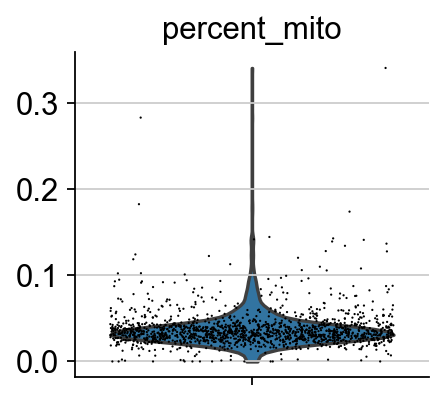

In [299]:
if qc_filter_genes == True:
    if adata.var_names[0].startswith("ENSG") == False:
        mito_genes = adata.var_names.str.startswith('MT-')    
    else:
        gene_symbol_var_names = adata.var_names
        mito_genes = [True if x in gene_id_map_dict and str(gene_id_map_dict[x]).startswith('MT-') else False for x in gene_symbol_var_names ]
    
    # for each cell compute fraction of counts in mito genes vs. all genes
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    
    sc.pl.violin(adata, ['percent_mito'],
             jitter=0.4, multi_panel=True)
    
    adata = adata[adata.obs.percent_mito < qc_threshold, :]
adata.raw = adata

# 3. Library Size Analysis

In order to quantify gene expression in an RNA-seq dataset, reads generated from the sequencing step are mapped to a reference genome and subsequently aggregated into numeric gene counts. Due to experimental variations and random technical noise, samples in an RNA-seq dataset often have variable amounts of the total RNA. Library size analysis calculates and displays the total number of reads mapped for each sample in the RNA-seq dataset, facilitating the identification of outlying samples and the assessment of the overall quality of the data.

In [300]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
library_sum_df = pd.DataFrame(adata.obs['n_counts'])
if len(library_sum_df.index) > 200:
    library_sum_df = library_sum_df.sample(200)
fig = px.bar(library_sum_df.sort_values(by='n_counts'), x=library_sum_df.index, y='n_counts')
if plot_type=='interactive':
    plotly.offline.iplot(fig)
else:
    py.image.ishow(fig)

# 4. Normalization

Various normalization methods can be applied based on the selection made by the user [3,4,5]. These normalization methods convert the raw read counts into standardized measures of gene expression by removing factors that may negatively affect the analysis.

filtered out 16 cells that have less than 200 genes expressed
filtered out 21425 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)


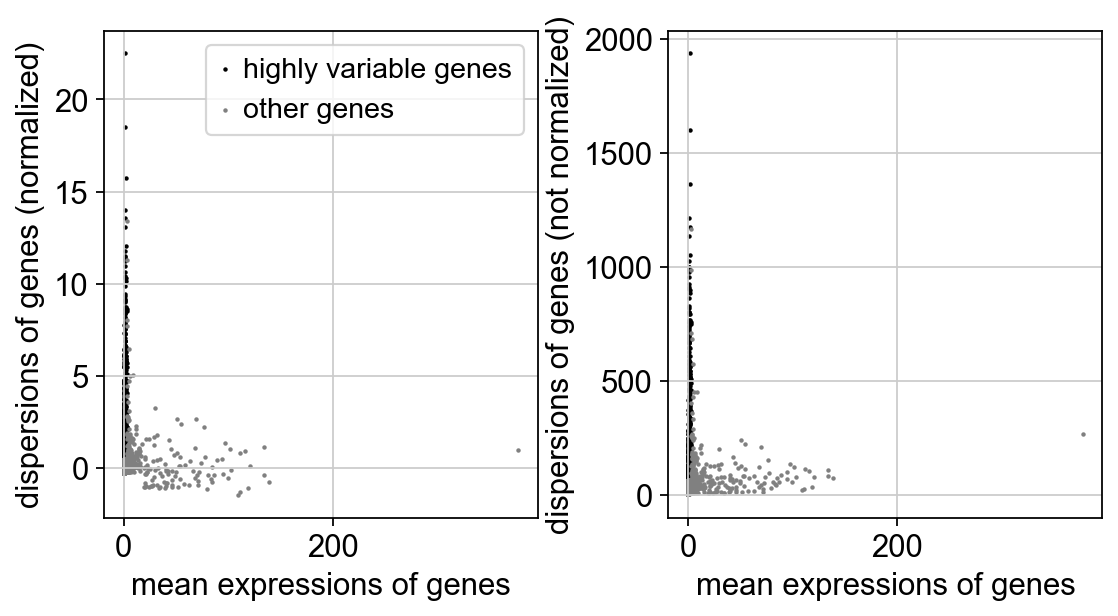

In [301]:
if normalization_method == "Zheng17":
    sc.pp.recipe_zheng17(adata, log=log_normalization, plot=True)
elif normalization_method == "Weinreb17":
    sc.pp.recipe_weinreb17(adata, log=log_normalization, plot=True)
elif normalization_method == "Seurat":
    sc.pp.recipe_seurat(adata, log=log_normalization, plot=True)

# 5. Most Highly Expressed Genes

This analysis displays the genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


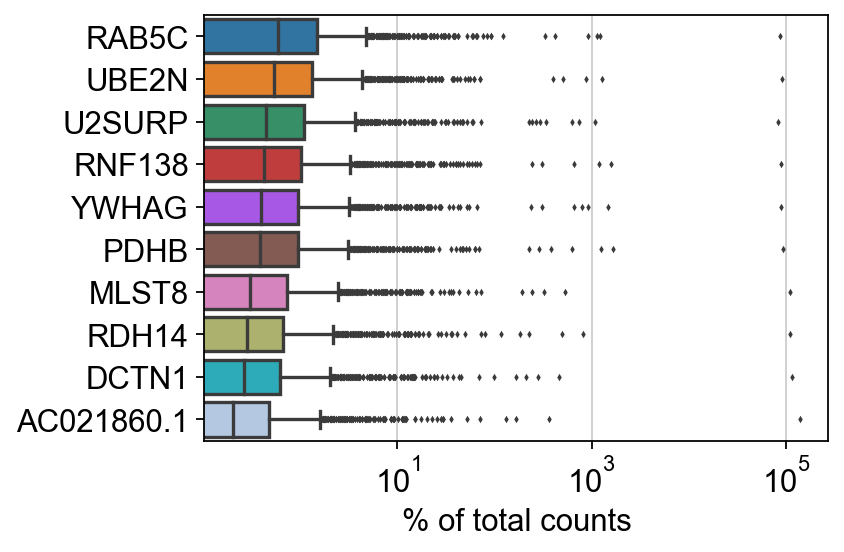

In [302]:
df = adata.to_df()
df = df.divide(df.sum(axis=1), axis=0)
mean_df = df.mean().sort_values(ascending=False)
yaxis_gene_names = list(mean_df.index)[:highest_expr_n_genes]
median_df = df.median().sort_values(ascending=False)
selected_median_df = median_df.loc[yaxis_gene_names]
sorted_yaxis_gene_names = list(selected_median_df.sort_values(ascending=False).index)
sc.pl.highest_expr_genes(adata, log=log_normalization, n_top=highest_expr_n_genes, order=sorted_yaxis_gene_names)

# 6. Plot the Samples

Principal Component Analysis (PCA ) [6], T-distributed Stochastic Neighbor Embedding (t-SNE) [7], Uniform Manifold Approximation and Projection (UMAP) [8] are statistical techniques used to identify global patterns in high-dimensional datasets. These techniques are commonly used to explore the similarity of biological samples in RNA-seq datasets. To achieve this, gene expression values are transformed into 2- or 3-dimensional latent vectors and subsequently visualized using a scatter plot.

In [303]:
def autoselect_color_by(sample_metadata):
    '''Automatically select a column in the sample_metadata df for coloring.
    '''
    color_by = None
    color_type = 'categorical'
    meta_col_nuniques = sample_metadata.nunique()
    # pick a column with the cardinality between 2 and 10
    meta_col_nuniques = meta_col_nuniques.loc[meta_col_nuniques.between(1, 30)]
    if len(meta_col_nuniques) > 0:
        color_by = meta_col_nuniques.index[0]
    else: # pick a numeric column
        is_number = np.vectorize(lambda x: np.issubdtype(x, np.number))
        meta_col_dtypes = sample_metadata.dtypes
        try:
            meta_col_is_number = is_number(meta_col_dtypes)
            if meta_col_is_number.sum() > 0:
                color_by = meta_col_dtypes.loc[meta_col_is_number].index[0]
                color_type = 'continuous'
        except:
            pass       
        
    return color_by, color_type

def run_dimension_reduction(dim_reduction_method, dataset, normalization=None, nr_genes=500, color_by='auto', color_type='categorical', plot_type='interactive'):
    if normalization == None:
        expression_dataframe = dataset.to_df()
        
    else:
        expression_dataframe = dataset.uns[normalization]
    # Run PCA
    if dim_reduction_method == "PCA":
        dim_red=PCA(n_components=3)
        dim_red.fit(expression_dataframe.T)

        # Get Variance
        var_explained = ['PC'+str((i+1))+'('+str(round(e*100, 1))+'% var. explained)' for i, e in enumerate(dim_red.explained_variance_ratio_)]
    elif dim_reduction_method == "t-SNE":
        dim_red = TSNE(n_components=3)
        dim_red.fit(expression_dataframe)
        
        var_explained = ['t-SNE 1', 't-SNE 2', 't-SNE 3']
    elif dim_reduction_method == "UMAP":
        dim_red = umap.UMAP(n_components=3)
        dim_red.fit(expression_dataframe)
        var_explained = ['UMAP 1', 'UMAP 2', 'UMAP 3']
        
        
    sample_metadata = pd.DataFrame(dataset.obs.loc[:, meta_class_column_name])
    # Estimate colors
    if color_by == 'auto':
        color_by, color_type = autoselect_color_by(sample_metadata)

    # Return
    dimension_reduction_results = {'result': dim_red, 'var_explained': var_explained, 'dim_reduction_method': dim_reduction_method,
        'sample_metadata': sample_metadata, 
        'color_by': color_by, 'color_type': color_type, 'nr_genes': nr_genes, 
        'plot_type': plot_type}
    return dimension_reduction_results

#############################################
########## 2. Plot
#############################################

def plot_dimension_reduction(dimension_reduction_results, return_data=False):
    # Get results
    dimension_reduction = dimension_reduction_results['result']
    var_explained = dimension_reduction_results['var_explained']
    sample_metadata = dimension_reduction_results['sample_metadata']
    color_by = dimension_reduction_results.get('color_by')
    color_type = dimension_reduction_results.get('color_type')
    color_column = dimension_reduction_results['sample_metadata'][color_by] if color_by else None
    if color_by:
        colors = sns.color_palette(n_colors=len(color_column.unique())).as_hex()
    dim_reduction_method = dimension_reduction_results["dim_reduction_method"]
    sample_titles = ['<b>{}</b><br>'.format(index)+'<br>'.join('<i>{key}</i>: {value}'.format(**locals()) for key, value in rowData.items()) for index, rowData in sample_metadata.iterrows()]
    
    if color_by and color_type == 'continuous':
        marker = dict(size=5, color=color_column, colorscale='Viridis', showscale=True)
        if dim_reduction_method == "PCA":
            trace = go.Scatter3d(x=dimension_reduction.components_[0],
                                 y=dimension_reduction.components_[1],
                                 z=dimension_reduction.components_[2],
                                 mode='markers',
                                 hoverinfo='text',
                                 text=sample_titles,
                                 marker=marker)
        elif dim_reduction_method == "t-SNE" or dim_reduction_method == "UMAP":
            trace = go.Scatter3d(x=dimension_reduction.embedding_[:,0],
                                 y=dimension_reduction.embedding_[:,1],
                                 z=dimension_reduction.embedding_[:,2],
                                 mode='markers',
                                 hoverinfo='text',
                                 text=sample_titles,
                                 marker=marker)
        data = [trace]
    elif color_by and color_type == 'categorical' and len(color_column.unique()) <= len(colors):
        # Get unique categories
        unique_categories = color_column.unique()
        # Define empty list
        data = []
            
        # Loop through the unique categories
        for i, category in enumerate(unique_categories):
            
            # Get the color corresponding to the category     
            category_color = colors[i]

            # Get the indices of the samples corresponding to the category
            category_indices = [i for i, sample_category in enumerate(color_column) if sample_category == category]
            
            # Create new trace
            if dim_reduction_method == "PCA":
                trace = go.Scatter3d(x=dimension_reduction.components_[0][category_indices],
                                     y=dimension_reduction.components_[1][category_indices],
                                     z=dimension_reduction.components_[2][category_indices],
                                     mode='markers',
                                     hoverinfo='text',
                                     text=[sample_titles[x] for x in category_indices],
                                     name = category,
                                     marker=dict(size=5, color=category_color))
            elif dim_reduction_method == "t-SNE" or dim_reduction_method == "UMAP":
                trace = go.Scatter3d(x=dimension_reduction.embedding_[category_indices, 0],
                                     y=dimension_reduction.embedding_[category_indices, 1],
                                     z=dimension_reduction.embedding_[category_indices, 2],
                                     mode='markers',
                                     hoverinfo='text',
                                     text=[sample_titles[x] for x in category_indices],
                                     name = category,
                                     marker=dict(size=5, color=category_color))
            
            # Append trace to data list
            data.append(trace)
    else:
        marker = dict(size=5)
        if dim_reduction_method == "PCA":
            trace = go.Scatter3d(x=dimension_reduction.components_[0],
                        y=dimension_reduction.components_[1],
                        z=dimension_reduction.components_[2],
                        mode='markers',
                        hoverinfo='text',
                        text=sample_titles,
                        marker=marker)
        elif dim_reduction_method == "t-SNE" or dim_reduction_method =="UMAP":
            trace = go.Scatter3d(x=dimension_reduction.embedding_[:,0],
                        y=dimension_reduction.embedding_[:,1],
                        z=dimension_reduction.embedding_[:,2],
                        mode='markers',
                        hoverinfo='text',
                        text=sample_titles,
                        marker=marker)
        data = [trace]

    colored = '' if str(color_by) == 'None' else 'Colored by {}'.format(color_by)
    layout = go.Layout(title='<b>{} Analysis | Scatter Plot</b><br><i>{}</i>'.format(dimension_reduction_results["dim_reduction_method"], colored), 
        hovermode='closest', margin=go.Margin(l=0,r=0,b=0,t=50), width=900,
        scene=dict(xaxis=dict(title=var_explained[0]), yaxis=dict(title=var_explained[1]),zaxis=dict(title=var_explained[2])))

    if return_data==True:
        return data, layout
    else:
        fig = go.Figure(data=data, layout=layout)

        if dimension_reduction_results['plot_type'] == 'interactive':
            plotly.offline.iplot(fig)
        else:
            py.image.ishow(fig)

In [304]:
# Run analysis
results['dimension_reduction'] = run_dimension_reduction(dim_reduction_method, dataset=adata, nr_genes=nr_genes, plot_type=plot_type)
# Display results
plot_dimension_reduction(results['dimension_reduction'])

# 7. MAGIC

Markov Affinity-based Graph Imputation of Cells (MAGIC) [9] is an algorithm for denoising high-dimensional data. It is most commonly applied to impute single-cell RNA sequencing data. MAGIC learns the manifold data, using the resultant graph to smooth the features and restore the original structure of the data.

In [305]:
def CPM(data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = (data/data.sum())*10**6
        data = data.fillna(0)

    return data
def normalize_magic(dataset, k=10, a=15, t='auto', n_pca=100, knn_dist='euclidean'):
    
    data_cpm = CPM(dataset.copy())
    
    # remove genes not expressed
    data_cpm = data_cpm.loc[data_cpm.sum(axis=1)>0]
    data_cpm = data_cpm.transpose()
    # square root transformation
    data_cpm = np.sqrt(data_cpm)
    
    magic_op = MAGIC(k=k, a=a, t=t, n_pca=n_pca, knn_dist=knn_dist)
    data_magic = magic_op.fit_transform(data_cpm)
    return data_magic.transpose()


def run_magic(dataset, dim_reduction_method, normalization='logCPM', plot_type='interactive'):
    # Run imputation
    dataset.uns['magic'] = normalize_magic(dataset.raw.to_adata().to_df().T)
    
    # Run PCA before/after
    before_magic = run_dimension_reduction(dim_reduction_method=dim_reduction_method, dataset=dataset, color_by=None)
    after_magic = run_dimension_reduction(dim_reduction_method=dim_reduction_method, dataset=dataset, normalization='magic', color_by=None)
    # PCA Plot 
    data_before_magic, layout_before = plot_dimension_reduction(before_magic, return_data=True)
    data_after_magic, layout_after = plot_dimension_reduction(after_magic, return_data=True)

    return {'data_before_magic': data_before_magic, 'layout_before': layout_before,
        'data_after_magic': data_after_magic, 'layout_after': layout_after,
        'plot_type': plot_type
        }

def plot_magic(magic_results, debug=False):

    fig = tools.make_subplots(rows=1, cols=2, 
                            specs=[[{'is_3d': True}, {'is_3d': True}]],
                            )

    for trace in magic_results['data_before_magic']:
        trace['scene'] = 'scene1'
        trace['name'] = 'before imputation'
        fig.append_trace(trace, 1, 1)
        
    for trace in magic_results['data_after_magic']:
        trace['name'] = 'after imputation'
        trace['scene'] = 'scene2'
        fig.append_trace(trace, 1, 2)
        
    fig['layout'].update(height=600, width=900, 
                        title='Before and after MAGIC imputation',
                        hovermode='closest',
                        margin=go.Margin(l=0,r=0,b=0,t=50)
                        )

    fig['layout']['scene1'].update(magic_results['layout_before']['scene'])
    fig['layout']['scene2'].update(magic_results['layout_after']['scene'])
    
    if magic_results['plot_type'] == "interactive":
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)
    

In [306]:
# Run analysis
results['magic_impute'] = run_magic(dataset=adata, dim_reduction_method="PCA", plot_type=plot_type)

# Display results
plot_magic(results['magic_impute'])

Calculating MAGIC...
  Running MAGIC on 1297 cells and 14464 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.62 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.17 seconds.
    Calculating affinities...
    Calculated affinities in 0.16 seconds.
  Calculated graph and diffusion operator in 0.98 seconds.
  Running MAGIC with `solver='exact'` on 14464-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
    Automatically selected t = 13
  Calculated imputation in 10.03 seconds.
Calculated MAGIC in 11.08 seconds.


# 8. Clustergrammer

Clustergrammer[10] is a web-based tool for visualizing and analyzing high-dimensional data as interactive and hierarchically clustered heatmaps. It is commonly used to explore the similarity between samples in an RNA-seq dataset. In addition to identifying clusters of samples, it also allows to identify the genes which contribute to the clustering. It visualizes the top 800 genes with largest variance by default or you can upload your gene list.

In [307]:
def display_link(url):
    raw_html = '<a href="%s" target="_blank">%s</a>' % (url, url)
    return display(HTML(raw_html))

In [308]:
def run_clustergrammer(dataset, nr_genes=800, metadata_cols=None, filter_samples=True,gene_list=None):
    # Subset the expression DataFrame using top 800 genes with largest variance
    data = adata.to_df().T
    variances = np.var(data, axis=1)
    srt_idx = variances.argsort()[::-1]
    if gene_list == None or len(gene_list) == 0:
        expr_df_sub = data.iloc[srt_idx].iloc[:nr_genes]
    else:
        gene_list = gene_list.split("\n")
        common_gene_list = list(set(gene_list).intersection(set(data.index)))
        expr_df_sub = data.loc[common_gene_list, :]
        assert len(expr_df_sub.index) > 0
    # prettify sample names
    sample_names = ['::'.join([y, x]) for x,y in
                       zip(meta_df[meta_class_column_name], expr_df_sub.columns)]
    expr_df_sub.columns = sample_names
    expr_df_sub.index = ["Gene: "+str(x) for x in expr_df_sub.index]
    sample_name = ["Sample: "+x for x in sample_names]
    expr_df_sub.columns = sample_name


    treatment_type = ["Class: "+ x.split("::")[1] for x in sample_names]
    new_series = pd.DataFrame(treatment_type).T
    new_series.columns = expr_df_sub.columns
    expr_df_sub = pd.concat([new_series, expr_df_sub], axis=0)

    index_list = list(expr_df_sub.index)
    index_list = ["" if "Gene" not in str(x) else x for x in index_list]
    expr_df_sub.index = index_list
    #subset of expr_df_sub
    if len(expr_df_sub.columns) > 400:
        expr_df_sub = expr_df_sub.sample(400, axis=1)
    expr_df_sub_file = "expr_df_sub_file.txt"
    expr_df_sub.to_csv("expr_df_sub_file.txt", sep='\t')
    # POST the expression matrix to Clustergrammer and get the URL
    clustergrammer_url = 'https://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'
    r = requests.post(clustergrammer_url, files={'file': open(expr_df_sub_file, 'rb')}).text
    return r
    
#############################################
########## 2. Plot
#############################################

def plot_clustergrammar(clustergrammer_url):
    clustergrammer_url = clustergrammer_url.replace("http:", "https:")
    display_link(clustergrammer_url)
    # Embed
    display(IPython.display.IFrame(clustergrammer_url, width="1000", height="1000"))

In [309]:
# Run analysis
results['clustergrammer'] = run_clustergrammer(dataset=adata, gene_list=gene_list_for_clustergrammer)

# Display results
plot_clustergrammar(results['clustergrammer'])

# 9. Differential Gene Expression

Gene expression signatures are alterations in the patterns of gene expression that occur as a result of cellular perturbations such as drug treatments, gene knock-downs or diseases. They can be quantified using differential gene expression (DGE) methods[11,12], which compare gene expression between two groups of samples to identify genes whose expression is significantly altered in the perturbation.

In [310]:
robjects.r('''limma <- function(rawcount_dataframe, design_dataframe, filter_genes=FALSE, adjust="BH") {
    
    # Load packages
    suppressMessages(require(limma))
    suppressMessages(require(edgeR))

    # Convert design matrix
    design <- as.matrix(design_dataframe)

    # Create DGEList object
    dge <- DGEList(counts=rawcount_dataframe)

    # Filter genes
    if (filter_genes) {
        keep <- filterByExpr(dge, design)
        dge <- dge[keep,]
    }

    # Calculate normalization factors
    dge <- calcNormFactors(dge)

    # Run VOOM
    v <- voom(dge, plot=FALSE)

    # Fit linear model
    fit <- lmFit(v, design)

    # Make contrast matrix
    cont.matrix <- makeContrasts(de=B-A, levels=design)

    # Fit
    fit2 <- contrasts.fit(fit, cont.matrix)

    # Run DE
    fit2 <- eBayes(fit2)

    # Get results
    limma_dataframe <- topTable(fit2, adjust=adjust, number=nrow(rawcount_dataframe))
    limma_dataframe$gene_symbol <- rownames(limma_dataframe)

    # Return
    return(limma_dataframe)
}
''')

R object with classes: ('function',) mapped to:

In [311]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

def run_cd(expr_df, sample_class):
    
    cd_res = geode.chdir(expr_df.values, sample_class, expr_df.index, gamma=.5, sort=False, calculate_sig=False)
    cd_coefs = np.array([x[0] for x in cd_res])
    cd_coefs_series = pd.DataFrame(cd_coefs)
    cd_coefs_series.index = expr_df.index
    cd_coefs_series.columns = ["coef"]
        
    return cd_coefs_series

def get_signatures(classes, dataset, method, filter_genes=True):
    expr_df = dataset.raw.to_adata().to_df().T
    meta_df = dataset.raw.to_adata().obs
    
    signatures = dict()
    if method == "limma":
        for A, B in combinations(classes, 2):
            group_A = meta_df.loc[meta_df[meta_class_column_name]==A].index.tolist()
            group_B = meta_df.loc[meta_df[meta_class_column_name]==B].index.tolist()

            design_dataframe = pd.DataFrame([{'index': x, 'A': int(x in group_A), 'B': int(x in group_B)} for x in expr_df.columns]).set_index('index')

            processed_data = {"expression": expr_df, 'design': design_dataframe}

            limma = robjects.r['limma']
            signature = pandas2ri.conversion.rpy2py(limma(pandas2ri.conversion.py2rpy(processed_data['expression']), pandas2ri.conversion.py2rpy(processed_data['design']), filter_genes))
            signature_label = "vs.".join([A, B])
            signatures[signature_label] = signature.sort_values("t", ascending=False)
        
    elif method == "characteristic_direction":
        meta_df = dataset.obs
        expr_df = dataset.to_df().T
        d_platform_cd = {} # to top up/down genes
        cd_results = dict()

        sample_classes = {}
        for A, B in combinations(classes, 2):    
            sample_class = np.zeros(expr_df.shape[1], dtype=np.int32)
            sample_class[meta_df[meta_class_column_name].values == A] = 1
            sample_class[meta_df[meta_class_column_name].values == B] = 2
            diff_gene_set_name = "vs.".join([A, B])
            sample_classes[diff_gene_set_name] = sample_class


        for signature_label, sample_class in sample_classes.items():

            signature = run_cd(expr_df, sample_class)
            signatures[signature_label] = signature.sort_values("coef", ascending=False)
    return signatures



In [312]:
classes = meta_df[meta_class_column_name].unique().tolist()
if len(classes) > 1:
    signatures = get_signatures(classes, adata, method="characteristic_direction")
    for label, signature in signatures.items():
        print("Label:", label)
        display(signature)
        display(create_download_link(signature))

# 10. Clustering

The Leiden algorithm [13] is a method to identify well-connected clusters in networks. 

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


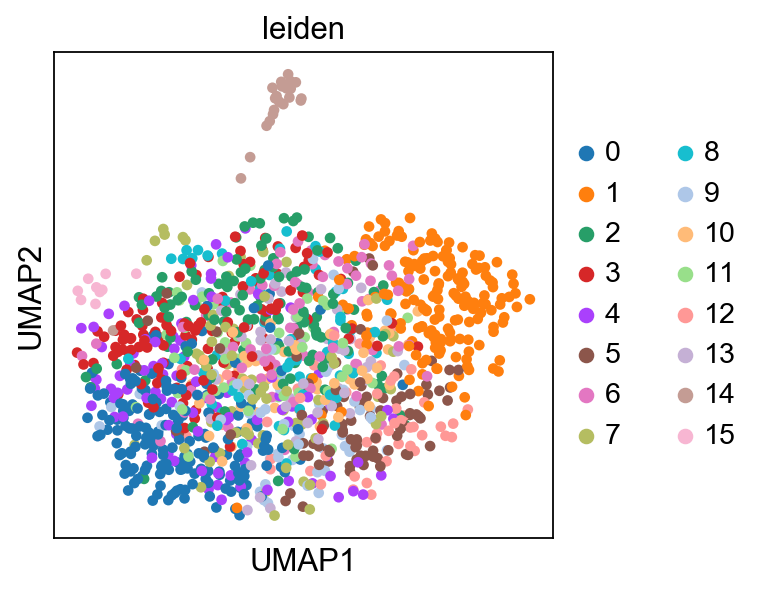

In [313]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.leiden(adata, resolution=1.0)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'])

# sc.tl.paga(adata, groups='leiden')
# sc.pl.paga(adata, color=['leiden', meta_class_column_name])

# 11. Trajectory Inference

Trajectory inference is a computational technique used in single-cell transcriptomics to arrange cells based on their progression through the differentiation process. It orders single cells in pseudotime, placing them along a trajectory corresponding to a biological process such as cell differentiation by taking advantage of single cells’ asynchronous progression through those processes. Diffusion pseudotime (DPT) [14], which measures transitions between cells using diffusion-like random walks is one of the methods used to identify such trajectories. Monocle [15] is a method for ordering cells by learning an explicit principal graph from the single cell expression data with advanced machine learning techniques (Reversed Graph Embedding), which robustly and accurately resolves complicated biological processes.

In [314]:
robjects.r('''
suppressMessages(library(dplyr))
suppressMessages(library(monocle))
suppressMessages(library(tibble))
suppressMessages(require(Matrix))
suppressMessages(require(VGAM))
suppressMessages(require(igraph))

# Make a CellDataSet object
# @expr_df: CPM expression data.frame (genes by samples) 
makeCellData <- function(expr_df) {
    genes <- rownames(expr_df)
    expr_mat = data.matrix(expr_df)
    num_cells_expressed <- (expr_mat > 0.1) + 0
    num_cells_expressed <- Matrix::rowSums(num_cells_expressed)
    fd <- data.frame(num_cells_expressed=num_cells_expressed, row.names = genes)
    fd <- new("AnnotatedDataFrame", data = fd)
    pd <- new("AnnotatedDataFrame", data = data.frame(row.names=colnames(expr_mat)))
    
    newCellDataSet(expr_mat,
        phenoData = pd,
        featureData = fd,
        lowerDetectionLimit = 0.1,
        expressionFamily = VGAM::tobit(0.1))
}

makeCellData3 <- function(expr_df) {
    genes <- rownames(expr_df)
    expr_mat = data.matrix(expr_df)
    num_cells_expressed <- (expr_mat > 0.1) + 0
    num_cells_expressed <- Matrix::rowSums(num_cells_expressed)
    fd <- data.frame(num_cells_expressed=num_cells_expressed, row.names = genes)
    fd <- new("AnnotatedDataFrame", data = fd)
    pd <- data.frame(row.names=colnames(expr_mat))
    # a hack to avoid error when running `partitionCells`
    pd['foo'] = 'bar'
    pd <- new("AnnotatedDataFrame", data = pd)
    
    newCellDataSet(expr_mat,
        phenoData = pd,
        featureData = fd,
        lowerDetectionLimit = 0.1)
}

getDEGsAsOrderingGenes <- function(cds){
    # get DEGs among clusters
    cds_expressed_genes <-  row.names(subset(fData(cds), num_cells_expressed >= 10))
    clustering_DEG_genes <- differentialGeneTest(cds[cds_expressed_genes,], 
        fullModelFormulaStr = '~Cluster',
        cores = 8)
    # order cells with top 1000 DEGs
    cds_ordering_genes <- row.names(clustering_DEG_genes)[order(clustering_DEG_genes$qval)][1:1000]
    cds_ordering_genes
}

getHighVarGenesAsOrderingGenes <- function(cds){
    # Use genes with highest variance as ordering genes
    RowVar <- function(x, ...) {
        # from https://stackoverflow.com/questions/25099825/row-wise-variance-of-a-matrix-in-r
        rowSums((x - rowMeans(x, ...))^2, ...)/(dim(x)[2] - 1)
    }
    # use genes with high variances for ordering cell
    gene_variances <- RowVar(exprs(cds))
    cds_ordering_genes <- names(gene_variances[order(gene_variances, decreasing = T)])[1:1000]
    cds_ordering_genes
}

# Run the entire Monocle-DDRTree pipeline to 
# 1) clustering
# 2) identify DEGs across clusters
# 3) ordering cells/psudotime estimation
runMonocleDDRTree <- function(cds, ordering = "de") {
    # tSNE and clustering cells
    cds <- reduceDimension(cds, 
        max_components = 2,
        norm_method = 'log',
        reduction_method = 'tSNE',
        perplexity = 5,
        verbose = T)

    n_cells <- as.numeric(dim(cds)[2])
    k <- 50 # default k for louvain clustering
    if (n_cells < 52){
        k <- n_cells - 2
    }
    cds <- clusterCells(cds, method="louvain", k=k, verbose = T)
    n_clusters <- length(unique(cds$Cluster))
    if (n_clusters > 1 && ordering == "de"){
        cds_ordering_genes <- tryCatch(
            {
                message("Attempting to compute DEGs across clusters for ordering cells...")
                getDEGsAsOrderingGenes(cds)
            },
            error=function(cond) {
                message("Error encountered while computing DEGs using monocle:")
                message(cond)
                message("Fall back to using most variable genes for ordering cells")
                getHighVarGenesAsOrderingGenes(cds)
            }
        )
    } else { # only 1 cluster
        message("Using most variable genes for ordering cells...")
        cds_ordering_genes <- getHighVarGenesAsOrderingGenes(cds)
    }
    cds <- setOrderingFilter(cds, ordering_genes = cds_ordering_genes)
    cds <- reduceDimension(cds, method = 'DDRTree', norm_method = 'log', 
        ncenter = NULL)
    cds <- orderCells(cds)
    return(cds)
}


runMonocleUMAPsimplePPT <- function(cds) {
    # 1. Noramlize and pre-process the data
    cds <- estimateSizeFactors(cds)
    cds <- preprocessCDS(cds, 
        num_dim = 50,
        norm_method = 'log',
        method = 'PCA'
        )
    # 2. Reduce the dimensionality of the data
    cds <- reduceDimension(cds, max_components = 3,
                           reduction_method = 'UMAP',
                           metric="cosine",
                           verbose = F)
    # 3. Partition the cells into supergroups
    cds <- partitionCells(cds)
    # 4. Learn the principal graph
    cds <- learnGraph(cds,
                      max_components = 3,
                      RGE_method = 'SimplePPT',
                      partition_component = T,
                      verbose = F)
    ## Not Implemented: Monocle 3 doesn't seem to support ordering by 
    # the expression of a list of genes. Will need know how to automatically
    # find the root cell instead.

    # # 5. order cells
    # cds <- orderCells(cds, 
    #     root_pr_nodes = get_correct_root_state(cds,
    #                                            cell_phenotype = 'cell_type2',
    #                                            "Multipotent progenitors"))
    return(cds)
}

# Convert cds object to edge_df and data_df for making plot
# @ref: https://github.com/cole-trapnell-lab/monocle-release/blob/ea83577c511564222bd08a35a9f944b07ccd1a42/R/plotting.R#L53
convertToDataFrames <- function(cds) {
    sample_name <- NA
    sample_state <- pData(cds)$State
    # data_dim_1 <- NA
    # data_dim_2 <- NA
    theta <- 0
    x <- 1
    y <- 2

    lib_info_with_pseudo <- pData(cds)

    reduced_dim_coords <- reducedDimK(cds)

    ica_space_df <- Matrix::t(reduced_dim_coords) %>%
      as.data.frame() %>%
      select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y) %>%
      mutate(sample_name = rownames(.), sample_state = rownames(.))

    dp_mst <- minSpanningTree(cds)

    edge_df <- dp_mst %>%
      igraph::as_data_frame() %>%
      select_(source = "from", target = "to") %>%
      left_join(ica_space_df %>% select_(source="sample_name", source_prin_graph_dim_1="prin_graph_dim_1", source_prin_graph_dim_2="prin_graph_dim_2"), by = "source") %>%
      left_join(ica_space_df %>% select_(target="sample_name", target_prin_graph_dim_1="prin_graph_dim_1", target_prin_graph_dim_2="prin_graph_dim_2"), by = "target")

    data_df <- t(monocle::reducedDimS(cds)) %>%
      as.data.frame() %>%
      select_(x = x, y = y) %>%
      rownames_to_column("sample_name") %>%
      mutate(sample_state) %>%
      left_join(lib_info_with_pseudo %>% rownames_to_column("sample_name"), by = "sample_name")

    return_rotation_mat <- function(theta) {
      theta <- theta / 180 * pi
      matrix(c(cos(theta), sin(theta), -sin(theta), cos(theta)), nrow = 2)
    }
    rot_mat <- return_rotation_mat(theta)

    cn1 <- c("x", "y")
    cn2 <- c("source_prin_graph_dim_1", "source_prin_graph_dim_2")
    cn3 <- c("target_prin_graph_dim_1", "target_prin_graph_dim_2")
    data_df[, cn1] <- as.matrix(data_df[, cn1]) %*% t(rot_mat)
    edge_df[, cn2] <- as.matrix(edge_df[, cn2]) %*% t(rot_mat)
    edge_df[, cn3] <- as.matrix(edge_df[, cn3]) %*% t(rot_mat)
    # Drop the redundant sample_state column
    data_df[,"sample_state"] = NULL
    return(list(edge_df=edge_df, data_df=data_df))
}


convertToDataFrames3 <- function(cds) {
    sample_name <- NA
    sample_state <- pData(cds)$louvain_component

    x <- 1
    y <- 2
    z <- 3

    lib_info_with_pseudo <- pData(cds)

    reduced_dim_coords <- reducedDimK(cds)

    ica_space_df <- Matrix::t(reduced_dim_coords) %>%
      as.data.frame() %>%
      select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y, prin_graph_dim_3 = z) %>%
      mutate(sample_name = rownames(.), sample_state = rownames(.))

    dp_mst <- minSpanningTree(cds)

    edge_df <- dp_mst %>%
      igraph::as_data_frame() %>%
      select_(source = "from", target = "to") %>%
      left_join(ica_space_df %>% select_(source="sample_name", source_prin_graph_dim_1="prin_graph_dim_1", 
          source_prin_graph_dim_2="prin_graph_dim_2", 
          source_prin_graph_dim_3="prin_graph_dim_3"), by = "source") %>%
      left_join(ica_space_df %>% select_(target="sample_name", target_prin_graph_dim_1="prin_graph_dim_1", 
          target_prin_graph_dim_2="prin_graph_dim_2", 
          target_prin_graph_dim_3="prin_graph_dim_3"), by = "target")

    data_df <- t(monocle::reducedDimS(cds)) %>%
      as.data.frame() %>%
      select_(x = x, y = y, z = z) %>%
      rownames_to_column("sample_name") %>%
      mutate(sample_state) %>%
      left_join(lib_info_with_pseudo %>% rownames_to_column("sample_name"), by = "sample_name")

    # Drop the redundant sample_state column
    data_df[,"sample_state"] = NULL
    return(list(edge_df=edge_df, data_df=data_df))
}

#  Run the entire Monocle pipeline
runMonoclePipeline <- function(expr_df, ordering = "de") {
    cds <- makeCellData(expr_df)
    cds <- runMonocleDDRTree(cds, ordering = ordering)
    convertToDataFrames(cds)    
}

runMonocle3Pipeline <- function(expr_df){
    cds <- makeCellData3(expr_df)
    cds <- runMonocleUMAPsimplePPT(cds)
    convertToDataFrames3(cds)
}
''')

R object with classes: ('function',) mapped to:

In [315]:
runMonoclePipeline = robjects.globalenv['runMonoclePipeline']
def run_monocle(dataset, color_by='Pseudotime', ordering='de', plot_type='interactive'):
    # Compute CPM
    dataset['CPM'] = CPM(dataset['rawdata'])
    data = dataset['CPM']
    # Run Monocle
    results_monocle = runMonoclePipeline(pandas2ri.conversion.py2rpy(data), ordering=ordering)
    monocle_results = {}
    for key in list(results_monocle.names):
        df = pandas2ri.conversion.rpy2py(results_monocle[int(np.where(results_monocle.names==key)[0][0])])
        monocle_results[key] = df

    monocle_results['data_df'].set_index('sample_name', inplace=True)
    monocle_results['sample_metadata'] = dataset['sample_metadata'].merge(
        monocle_results['data_df'],
        left_index=True,
        right_index=True
        )
    # Return
    monocle_results.update(
        {'color_by': color_by, 'plot_type': plot_type}
        )
    return monocle_results

def plot_monocle(monocle_results, debug=False):
    # Get results
    sample_metadata = monocle_results['sample_metadata']
    color_by = monocle_results.get('color_by')

    color_type = 'continuous'
    if color_by == 'State':
        color_type = 'categorical'
        
    color_column = monocle_results['sample_metadata'][color_by] if color_by else None
    sample_titles = ['<b>{}</b><br>'.format(index)+'<br>'.join('<i>{key}</i>: {value}'.format(**locals()) for key, value in rowData.items()) for index, rowData in sample_metadata.iterrows()]

    # Make a trace for the trajectory
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=1,color='#888'),
        hoverinfo='none',
        name='trajectory',
        mode='lines')

    for _, row in monocle_results['edge_df'].iterrows():
        x0, y0 = row['source_prin_graph_dim_1'], row['source_prin_graph_dim_2']
        x1, y1 = row['target_prin_graph_dim_1'], row['target_prin_graph_dim_2']
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)
    
    if color_by and color_type == 'continuous':
        marker = dict(size=5, color=color_column, colorscale='Viridis', showscale=True)
        trace = go.Scatter(x=monocle_results['data_df']['x'],
            y=monocle_results['data_df']['y'],
            mode='markers',
            hoverinfo='text',
            text=sample_titles,
            marker=marker,
            name='Cells'
            )
        data = [trace, edge_trace]

    elif color_by and color_type == 'categorical' and len(color_column.unique()) <= len(s.colors):

        # Get unique categories
        unique_categories = color_column.unique()

        # Define empty list
        data = []
            
        # Loop through the unique categories
        for i, category in enumerate(unique_categories):

            # Get the color corresponding to the category
            category_color = s.colors[i]

            # Get the indices of the samples corresponding to the category
            category_indices = [i for i, sample_category in enumerate(color_column) if sample_category == category]
            
            # Create new trace
            trace = go.Scatter(x=monocle_results['data_df']['x'].values[category_indices],
                                 y=monocle_results['data_df']['y'].values[category_indices],
                                 mode='markers',
                                 hoverinfo='text',
                                 text=[sample_titles[x] for x in category_indices],
                                 name = category,
                                 marker=dict(size=5, color=category_color))
            
            # Append trace to data list
            data.append(trace)
        data.append(edge_trace)
    else:
        marker = dict(size=5)
        trace = go.Scatter(x=monocle_results['data_df']['x'],
                    y=monocle_results['data_df']['y'],
                    mode='markers',
                    hoverinfo='text',
                    text=sample_titles,
                    marker=marker)
        data = [trace, edge_trace]
    
    colored = '' if str(color_by) == 'None' else 'Colored by {}'.format(color_by)
    layout = go.Layout(title='<b>Monocle Analysis | Cell Trajectory Plot</b><br><i>{}</i>'.format(colored), hovermode='closest', margin=go.Margin(l=0,r=0,b=0,t=50), width=900,
        scene=dict(xaxis=dict(title='Component 1'), yaxis=dict(title='Component 2')))
    fig = go.Figure(data=data, layout=layout)
    if monocle_results['plot_type']=='interactive':
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:04)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9739578  0.832278   0.8171463  0.78446347 0.76527613
     0.7377589  0.72870964 0.7231653  0.721468   0.71828425 0.7123879
     0.7094911  0.7082253  0.70717585]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


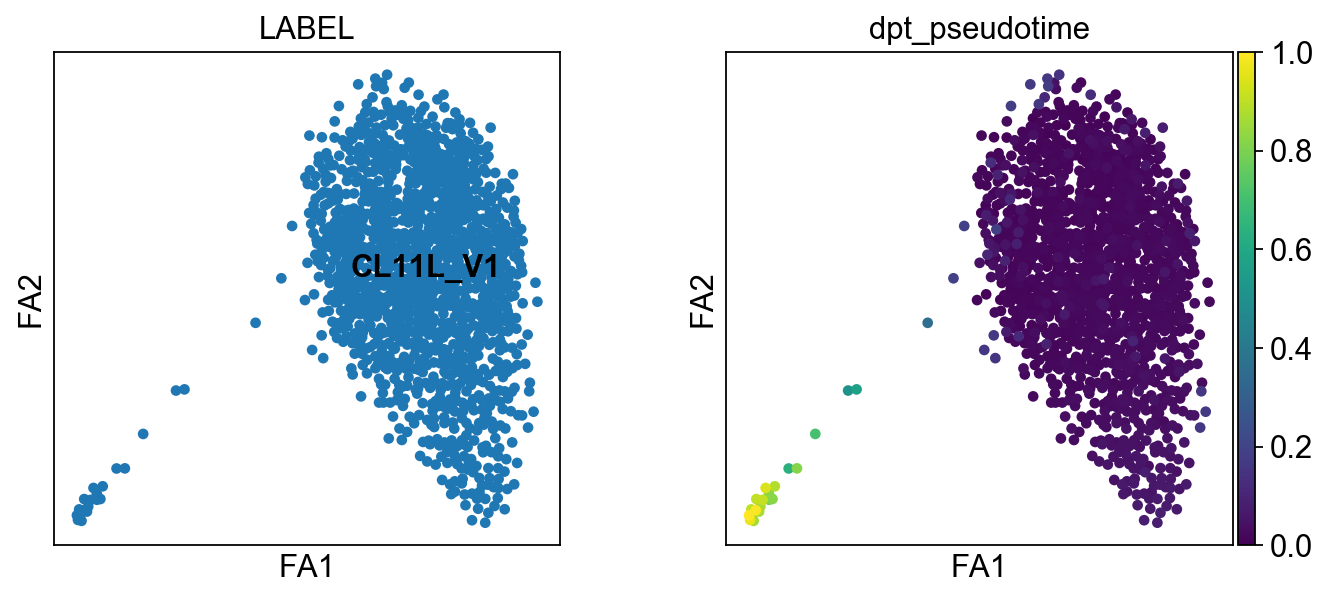

In [316]:
if trajectory_method == "monocle":
    # Run analysis
    results['monocle'] = run_monocle(dataset=dataset, plot_type=plot_type, color_by='Pseudotime')

    # Display results
    plot_monocle(results['monocle'])
elif trajectory_method == "dpt":
    adata.uns['iroot'] = 0
    sc.tl.draw_graph(adata)
    sc.tl.dpt(adata)
    sc.pl.draw_graph(adata, color=[meta_class_column_name, 'dpt_pseudotime'], legend_loc='on data')

# 12. Time-series Trajectory Analysis

When time-series data is available, it is possible to order cells by their progression through a dynamic
process using time information. Tempora [16], a pathway-based cell trajectory inference method that orders cells using time information from the data, infers developmental linages based on biological pathway information. This time-series based analysis can generate insights into dynamic processes and their biological regulation. 

In [317]:
robjects.r('''
library(Seurat)
library(Tempora)
library(snow)
library(RColorBrewer)
library(igraph)

#overwrite a function of Tempora
BuildTrajectory <- function(object, n_pcs, difference_threshold=0.01){

  if (class(object)[1] != "Tempora"){
    stop("Not a valid Tempora object")
  }


  if (n_pcs > ncol(object@cluster.pathways.dr$rotation)){
    stop("Number of PCs selected exceeds number of PCs calculated")
  }

  significant_pathways_list <- gsva_pca <- list()
  for (i in 1:n_pcs){
    genes_scaled <- scale(object@cluster.pathways.dr$rotation[,i])
    significant_pathways_list[[i]] <- object@cluster.pathways[which(rownames(object@cluster.pathways) %in% names(which(genes_scaled[,1] > 1.0 | genes_scaled[,1] < -1.0))), ]
    gsva_pca[[i]] <- colMeans(significant_pathways_list[[i]])
  }

  gsva_pca <- Reduce(rbind, gsva_pca)
  rownames(gsva_pca) <- paste0("PC", seq(1:nrow(gsva_pca)))

  mi_network <- bnlearn::aracne(as.data.frame(gsva_pca))
  edges_df <- as.data.frame(mi_network$arcs)
  edges_df$to <- as.numeric(as.character(edges_df$to))
  edges_df$from <- as.numeric(as.character(edges_df$from))
  edges_df$from_clusterscore <- unlist(sapply(edges_df$from, function(x) object@cluster.metadata$Cluster_time_score[object@cluster.metadata$Id == x]))
  edges_df$to_clusterscore <- unlist(sapply(edges_df$to, function(x) object@cluster.metadata$Cluster_time_score[object@cluster.metadata$Id == x]))


  edges_df$direction <- ifelse((abs(edges_df$to_clusterscore - edges_df$from_clusterscore)/(0.5*(edges_df$to_clusterscore + edges_df$from_clusterscore))) < difference_threshold, "bidirectional", "unidirectional")
  edges_df <- edges_df[-which(edges_df$from_clusterscore > edges_df$to_clusterscore), ]
  edges_df$id <- ifelse(as.numeric(edges_df$from) > as.numeric(edges_df$to), paste0(edges_df$from, edges_df$to), paste0(edges_df$to, edges_df$from))
  edges_df <- edges_df[!duplicated(edges_df$id), ]
  edges_df <- edges_df[, -6]
  edges_df$type <-  ifelse(edges_df$direction == "bidirectional", 3, 1)

  object@trajectory <- edges_df
  object@n.pcs <- n_pcs
  return(object)
}

#overwrite a function of Tempora
PlotTrajectory <- function(object, plotname, layout=NULL, ...){

  if (class(object)[1] != "Tempora"){
    stop("Not a valid Tempora object")
  }

  if (is.null(object@trajectory)){
    stop("BuildTrajectory has not been run. See ?Tempora::BuildTrajectory for details")
  }
  #png("myplots.png", 600, 600)
  edge_graph <- igraph::graph_from_data_frame(d=object@trajectory, vertices = object@cluster.metadata, directed = T)
  if (is.null(layout)){
    l <- igraph::layout_with_sugiyama(edge_graph, layers = object@cluster.metadata$Cluster_time_score, maxiter = 1000)
    #l$layout[,2] <- 3-(rescale(object@cluster.metadata$Cluster_time_score, to=c(0,3)))
    if (length(levels(object@meta.data$Timepoints)) > 9){
      colours <- colorRampPalette(RColorBrewer::brewer.pal(7, "YlOrRd"))
      jpeg('rplot2.jpg')
      plot.igraph(edge_graph, ylim=c(-1,1), layout = l$layout, ylab = "Inferred time", vertex.shape = "pie", vertex.pie = lapply(1:nrow(object@cluster.metadata), function(x) as.numeric(object@cluster.metadata[x,2:((length(levels(object@meta.data$Timepoints)))+1)])),
                  vertex.pie.color=list(colours(length(levels(object@meta.data$Timepoints)))), pie.border=list(rep("white", 4)), vertex.frame.color="white", edge.arrow.size = 0.5, edge.width = 1.5, vertex.label.family="Arial",
                  vertex.label.color="black", edge.lty = E(edge_graph)$type, ...)
      axis(side=2, at=c(-1,1), labels=c("Late","Early"), las=1)
      legend("topleft", legend = levels(object@meta.data$Timepoints), fill=colours, bty = "n", border="black")
    } else {
      colours <- brewer.pal(length(levels(object@meta.data$Timepoints)), "YlOrRd")
      jpeg('rplot2.jpg')
      plot.igraph(edge_graph, ylim=c(-1,1), ylab = "Inferred time", layout = l$layout, vertex.shape = "pie", vertex.pie = lapply(1:nrow(object@cluster.metadata), function(x) as.numeric(object@cluster.metadata[x,2:((length(levels(object@meta.data$Timepoints)))+1)])),
                  vertex.pie.color=list(colours), pie.border=list(rep("white", length(levels(object@meta.data$Timepoints)))), vertex.frame.color="white",
                  vertex.label.family="Arial", vertex.label.color="black", edge.lty = E(edge_graph)$type,...)
      legend("topleft", legend = levels(object@meta.data$Timepoints), fill=colours, bty = "n", border = "black")
      axis(side=2, at=c(-1,1), labels=c("Late","Early"), las=1)
    }
    object@layouts <- l$layout

  } else {
    if (length(levels(object@meta.data$Timepoints)) > 9){
      colours <- colorRampPalette(RColorBrewer::brewer.pal(7, "YlOrRd"))
      
      plot.igraph(edge_graph, ylim=c(-1,1), layout = layout, ylab = "Inferred time", vertex.shape = "pie", vertex.pie = lapply(1:nrow(object@cluster.metadata), function(x) as.numeric(object@cluster.metadata[x,2:((length(levels(object@meta.data$Timepoints)))+1)])),
                  vertex.pie.color=list(colours(length(levels(object@meta.data$Timepoints)))), pie.border=list(rep("white", 4)), vertex.frame.color="white", edge.arrow.size = 0.5, edge.width = 1.5, vertex.label.family="Arial",
                  vertex.label.color="black", edge.lty = E(edge_graph)$type, ...)
      axis(side=2, at=c(-1,1), labels=c("Late","Early"), las=1)
      legend("topleft", legend = levels(object@meta.data$Timepoints), fill=colours, bty = "n", border="black")
      
    } else {
      colours <- brewer.pal(length(levels(object@meta.data$Timepoints)), "YlOrRd")
      
      plot.igraph(edge_graph, ylim=c(-1,1), ylab = "Inferred time", layout = layout, vertex.shape = "pie", vertex.pie = lapply(1:nrow(object@cluster.metadata), function(x) as.numeric(object@cluster.metadata[x,2:((length(levels(object@meta.data$Timepoints)))+1)])),
                  vertex.pie.color=list(colours), pie.border=list(rep("white", length(levels(object@meta.data$Timepoints)))), vertex.frame.color="white",
                  vertex.label.family="Arial", vertex.label.color="black", edge.lty = E(edge_graph)$type,...)
      legend("topleft", legend = levels(object@meta.data$Timepoints), fill=colours, bty = "n", border = "black")
      axis(side=2, at=c(-1,1), labels=c("Late","Early"), las=1)
      
    }
  }
  jpeg(plotname)
  plot(edge_graph, ylim=c(-1,1), ylab = "Inferred time", layout = layout, vertex.shape = "pie", vertex.pie = lapply(1:nrow(object@cluster.metadata), function(x) as.numeric(object@cluster.metadata[x,2:((length(levels(object@meta.data$Timepoints)))+1)])),
                  vertex.pie.color=list(colours), pie.border=list(rep("white", length(levels(object@meta.data$Timepoints)))), vertex.frame.color="white",
                  vertex.label.family="Arial", vertex.label.color="black", edge.lty = E(edge_graph)$type,...)
  legend("topleft", legend = levels(object@meta.data$Timepoints), fill=colours, bty = "n", border = "black")
  axis(side=2, at=c(-1,1), labels=c("Late","Early"), las=1)
  dev.off()
  validObject(object)
  return(object)
}

loadData <- function(rnaseq_data_filename, meta_data_filename, cluster_column_name, timepoint_column_name, timpoint_order_list, plotname){
    raw_counts = read.csv(rnaseq_data_filename, row.names = 1)
    meta = read.csv(meta_data_filename, row.names = 1)
    
    #create Seurat object
    seu <- CreateSeuratObject(raw.data=raw_counts,meta.data=meta,names.delim="?",names.field=1,normalization.method="LogNormalize")
    
    #convert Seurat object to Tempora object
    seu_tempora <- ImportSeuratObject(seu, assayType="RNA", clusters = cluster_column_name,
                                     timepoints = timepoint_column_name,
                                     timepoint_order = timpoint_order_list)
                                     
    seu_tempora <- CalculatePWProfiles(seu_tempora, 
                gmt_path = "Human_GOBP_AllPathways_no_GO_iea_June_01_2020_symbol.gmt",
                method="gsva", min.sz = 5, max.sz = 200, parallel.sz = 1)
                
                
    #Build trajectory with 2 PCs 
    seu_tempora <- BuildTrajectory(seu_tempora, n_pcs = 2, difference_threshold = 0.01)

    #Visualize the trajectory
    seu_tempora <- PlotTrajectory(seu_tempora, plotname)
    return (seu_tempora)
}
''')


R object with classes: ('function',) mapped to:

In [333]:
if time_series_trajectory == True:
    #download Human_GOBP_AllPathways_no_GO_iea_June_01_2020_symbol.gmt 
    url = "http://download.baderlab.org/EM_Genesets/current_release/Human/symbol/Human_GOBP_AllPathways_no_GO_iea_June_01_2020_symbol.gmt"
    r = requests.get(url, allow_redirects=True)
    open('Human_GOBP_AllPathways_no_GO_iea_June_01_2020_symbol.gmt', "wb").write(r.content)
    tmp_meta_df = adata.obs.copy()
    tmp_meta_df["Timepoints"] = tmp_meta_df[timepoint_labels_column_name]
    tmp_meta_df["leiden"] = tmp_meta_df["leiden"].astype('int')
    tmp_meta_df["leiden"] = tmp_meta_df["leiden"] + 1
    if len(tmp_meta_df["Timepoints"].unique()) > 1:
        #generate a temporary folder to save results
        now = datetime.now()
        temporary_folder_name = "tmp{}/".format(now.strftime("%Y%m%d%H%M%S"))
        os.mkdir(temporary_folder_name)
        
        #save preprocessed data
        tmp_meta_df.to_csv(temporary_folder_name+"metadata_with_clusters.csv")
        adata.raw.to_adata().to_df().T.to_csv(temporary_folder_name+"expressiondata_after_preprocessing.csv")

        loadData = robjects.r['loadData']
        loadData(temporary_folder_name+"expressiondata_after_preprocessing.csv", temporary_folder_name+"metadata_with_clusters.csv", "leiden", "Timepoints", timepoint_labels.split("\n"), "plot.jpg")


KeyError: 'Timepoints'

In [346]:
if time_series_trajectory == True:
    # save time-series trajectory inference as image
    display(FileLink("plot.jpg", result_html_prefix="Download jpg file "))
    shutil.rmtree('tmp{}'.format(now.strftime("%Y%m%d%H%M%S")))

/Users/maayan/minji/python_projects/jupyter_template/jupyter-template-catalog/appyters/SC_RNA_seq/rplot.jpg

# 13. Enrichment Analysis

Enrichment analysis is a bioinformatics method used to identify prior knowledge terms which are over-represented in a given gene set by comparing the gene set to many annotated gene sets. The prior-knowledge gene sets can represent cell signaling pathways, molecular functions, diseases, and a wide variety of other terms obtained by processing data from multiple resources. Enrichr [17] is a web-based application that  performs enrichment analysis against a large collection of gene-set libraries. It provides various interactive visualizations to display enrichment results.

In [320]:
def _rank_genes_wrapper(d, plot=False):
    categories = adata.uns['rank_genes_groups']['names'].dtype.names
    topk_ranked_genes = dict()
    for i in range(len(categories)):
        topk_ranked_genes_by_category = []
        for j in range(len(adata.uns['rank_genes_groups']['names'])):
            
            gene_name = adata.uns['rank_genes_groups']['names'][j][i]
            logfc = d["logfoldchanges"][j][i]
            pvals = d["pvals"][j][i]
            pvals_adj = d["pvals_adj"][j][i]
            topk_ranked_genes_by_category.append([gene_name, logfc, pvals, pvals_adj])
            
        tmpdf = pd.DataFrame(topk_ranked_genes_by_category)
        tmpdf.columns = ["Gene symbol", "logFC", "pvals", "pvals_adj"]
        tmpdf = tmpdf.set_index("Gene symbol")
        topk_ranked_genes[categories[i]] = tmpdf
        if plot == True:
            display(Markdown("Gene signature table for {}".format(categories[i])))
            display(tmpdf)
    return topk_ranked_genes


In [321]:
def get_genesets(signature_dataframe, signature_col, top_n=True, nr_genes=500):
    genesets = {}
    sorted_genes = signature_dataframe.sort_values(signature_col).index
    genesets['upregulated'] = sorted_genes[-nr_genes:]
    genesets['downregulated'] = sorted_genes[:nr_genes]
    return genesets

def submit_enrichr_geneset(geneset, label):
    ENRICHR_URL = 'https://amp.pharm.mssm.edu/Enrichr/addList'
    genes_str = '\n'.join(geneset)
    payload = {
        'list': (None, genes_str),
        'description': (None, label)
    }
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    time.sleep(0.5)
    data = json.loads(response.text)
    return data

def run_enrichr(signatures, geneset_size=100, libraries=['GO_Biological_Process_2017b', 'ENCODE_TF_ChIP-seq_2015', 'KEGG_2016', 'ARCHS4_TFs_Coexp', 'MGI_Mammalian_Phenotype_2017'], signature_label=''):
    # Get genesets
    genesets = {cluster_name: signature.index[:geneset_size] for cluster_name, signature in signatures.items()}

    # Submit to Enrichr
    enrichr_ids = {geneset_label: submit_enrichr_geneset(geneset=geneset, label=geneset_label) for geneset_label, geneset in genesets.items()}
    return enrichr_ids

#############################################
########## 2. Plot
#############################################

def plot_enrichr(enrichr_ids):
    markdown_text = '##### Signature genes from each clusters:\n'
    for cluster_name, enrichr_res in enrichr_ids.items():
#         markdown_text += ' + **%s:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=%s \n' % (cluster_name, enrichr_res['shortId'])
        print(cluster_name+":\r")
        url = "https://amp.pharm.mssm.edu/Enrichr/enrich?dataset={}".format(enrichr_res['shortId'])
        display_link(url)
#     display(Markdown(markdown_text))


In [322]:
def get_signature(enrichment_groupby, dataset, method='wilcoxon', nr_genes=200):
    if enrichment_groupby == "cluster":
        sc.tl.rank_genes_groups(dataset, 'leiden', method=method, n_genes=nr_genes)
    elif enrichment_groupby == "cell_type":
        sc.tl.rank_genes_groups(dataset, meta_class_column_name, method=method, n_genes=nr_genes)
        
    return dataset

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


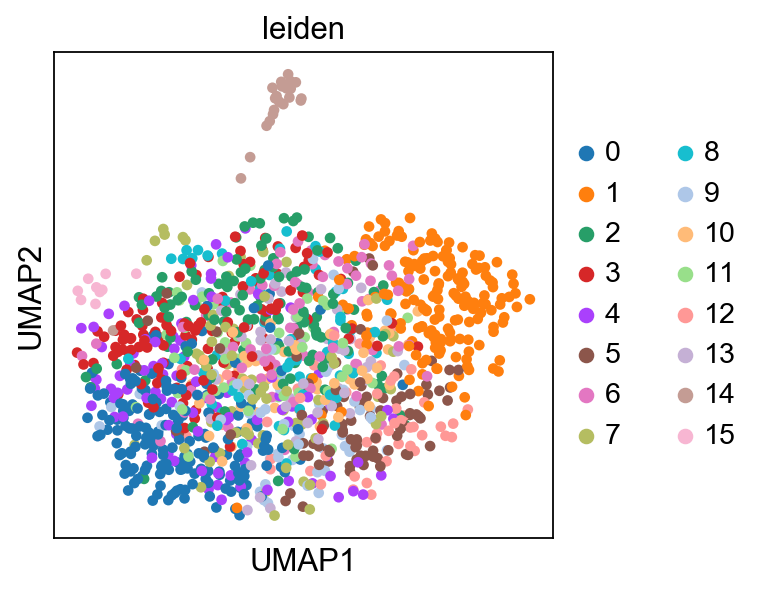

0:


1:


2:


3:


4:


5:


6:


7:


8:


9:


10:


11:


12:


13:


14:


15:


In [323]:
# Run analysis
adata = get_signature(enrichment_groupby=enrichment_groupby, dataset=adata, nr_genes=nr_genes)
signatures = _rank_genes_wrapper(adata.uns['rank_genes_groups'])

results['enrichr'] = run_enrichr(signatures=signatures, geneset_size=200)
sc.pl.umap(adata, color=['leiden'])

# Display results
plot_enrichr(results['enrichr'])

# 14. Gene Ontology Enrichment Analysis

Gene Ontology (GO) [18] is a major initiative aimed at unifying the representation of gene attributes across all species. It contains a large collection of experimentally validated and predicted associations between genes and biological terms. This information can be leveraged by Enrichr to identify enriched biological processes, molecular functions and cellular components which are over-represented in the up-regulated genes from each cluster.

In [324]:
def get_enrichr_results(user_list_id, gene_set_libraries, overlappingGenes=True, geneset=None):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    results = []
    for gene_set_library, label in gene_set_libraries.items():
        response = requests.get(
                    ENRICHR_URL +
                       query_string % (user_list_id, gene_set_library)
                )
        if not response.ok:
            raise Exception('Error fetching enrichment results')

        data = json.loads(response.text)
        resultDataframe = pd.DataFrame(data[gene_set_library], columns=[
                                       'rank', 'term_name', 'pvalue', 'zscore', 'combined_score', 'overlapping_genes', 'FDR', 'old_pvalue', 'old_FDR'])
        selectedColumns = ['term_name', 'zscore', 'combined_score', 'pvalue', 'FDR'] if not overlappingGenes else [
            'term_name', 'zscore', 'combined_score', 'FDR', 'pvalue', 'overlapping_genes']
        resultDataframe = resultDataframe.loc[:, selectedColumns]
        resultDataframe['gene_set_library'] = label
        resultDataframe['log10P'] = -np.log10(resultDataframe['pvalue'])
        results.append(resultDataframe)
    concatenatedDataframe = pd.concat(results)
    if geneset:
        concatenatedDataframe['geneset'] = geneset
    return concatenatedDataframe


def run_go(enrichr_results, plot_type='interactive', nr_genesets=10):
    
    # Libraries
    libraries = {
        'GO_Biological_Process_2018': 'Gene Ontology Biological Process',
        'GO_Molecular_Function_2018': 'Gene Ontology Molecular Function',
        'GO_Cellular_Component_2018': 'Gene Ontology Cellular Component'
    }

    # Get Enrichment Results
    enrichment_results = {geneset_label: get_enrichr_results(enrichr_ids['userListId'], gene_set_libraries=libraries, geneset=geneset_label) 
        for geneset_label, enrichr_ids in enrichr_results.items()}

    # Return
    return {'enrichment_results': enrichment_results, 'plot_type': plot_type, "nr_genesets":nr_genesets}

def plot_go(enrichr_results):
    # Create dataframe
    enrichment_dataframe = pd.concat(enrichr_results['enrichment_results'].values())

    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()
    if len(libraries):

        # Barcharts
        for gene_set_library in libraries:
            plot_library_barchart(enrichr_results, gene_set_library, enrichr_results["nr_genesets"], 300)


def plot_library_barchart(enrichr_results, gene_set_library, nr_genesets, height):
    # Calculate the number of subplots
    n_panels = len(enrichr_results['enrichment_results']) # 2 <= n_panels <= 10
    n_rows = math.ceil(n_panels / 3)
    n_cols = min(n_panels, 3)
    color_dict = {"Gene Ontology Biological Process": "#F59EA5", 
              "Gene Ontology Molecular Function": "#B0CFFF", 
              "Gene Ontology Cellular Component": "#FFEA9A"}
    
    colors = [color_dict[gene_set_library]]*len(enrichr_results['enrichment_results'].keys())
    
    fig = tools.make_subplots(rows=n_rows, cols=n_cols, print_grid=False, 
        subplot_titles=list(enrichr_results['enrichment_results'].keys()))
    for i, geneset in enumerate(enrichr_results['enrichment_results'].keys()):
        # Get dataframe
        enrichment_dataframe = enrichr_results['enrichment_results'][geneset]
        plot_dataframe = enrichment_dataframe[enrichment_dataframe['gene_set_library'] == gene_set_library].sort_values(
            'combined_score', ascending=False).iloc[:nr_genesets].iloc[::-1]

        # Format
        n = 7
        plot_dataframe['nr_genes'] = [len(genes) for genes in plot_dataframe['overlapping_genes']]
        plot_dataframe['overlapping_genes'] = ['<br>'.join([', '.join(genes[i:i+n]) for i in range(0, len(genes), n)]) for genes in plot_dataframe['overlapping_genes']]
        
        # Get Bar
        bar = go.Bar(
            x=plot_dataframe['combined_score'],
            y=plot_dataframe['term_name'],
            orientation='h',
            name=geneset.title(),
            showlegend=False,
            hovertext=['<b>{term_name}</b><br><b>P-value</b>: <i>{pvalue:.2}</i><br><b>FDR</b>: <i>{FDR:.2}</i><br><b>Z-score</b>: <i>{zscore:.3}</i><br><b>Combined score</b>: <i>{combined_score:.3}</i><br><b>{nr_genes} Genes</b>: <i>{overlapping_genes}</i><br>'.format(**rowData) 
                for index, rowData in plot_dataframe.iterrows()],
            hoverinfo='text',
            marker={'color': colors[i]}
        )
        row = math.ceil( (i+1) / 3 )
        col = (i+1) % 3
        if col == 0:
            col = 3
        fig.append_trace(bar, row, col)

        # Get text
        text = go.Scatter(
            x=[max(bar['x'])/50 for x in range(len(bar['y']))],
            y=bar['y'],
            mode='text',
            hoverinfo='none',
            showlegend=False,
            text=['*<b>{}</b>'.format(rowData['term_name']) if rowData['FDR'] < 0.1 else '{}'.format(
                rowData['term_name']) for index, rowData in plot_dataframe.iterrows()],
            textposition="middle right",
            textfont={'color': 'black'}
        )
        fig.append_trace(text, row, col)

    domains = [(0, 0.49), (0.51, 1)]
    if n_cols == 3:
        domains = [(0, 0.31), (0.33, 0.64), (0.66, 1)] * 10
    
    # Get title
    title = gene_set_library

    fig['layout'].update(height=height*n_rows, title='<b>{}</b>'.format(title),
                         hovermode='closest')    
    
    for i in range(n_panels):
        fig['layout']['xaxis%d' % (i+1)].update(domain=domains[i], title='', automargin=True)
        fig['layout']['yaxis%d' % (i+1)].update(showticklabels=False, automargin=True)

    fig['layout']['margin'].update(l=0, t=65, r=0, b=30)
    
    if enrichr_results['plot_type']=='interactive':
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)
    

In [325]:
# Run analysis
results['go_enrichment'] = run_go(enrichr_results=results['enrichr'], plot_type=plot_type, nr_genesets=nr_genesets)

    # Display results
plot_go(results['go_enrichment'])

# 15. Cell Type Prediction with DigitalCellSorter 

DigitalCellSorter [19] is an unbiased cell type recognition algorithm for scRNA-seq. It leverages a manual assessment using a few selected markers of cell types and infers the cell of origin for each of the single cells independently.

In [326]:
DCS = DigitalCellSorter.DigitalCellSorter(nComponentsPCA=3)
DCS.annotationMethod='ratio'
DCS.makePlots = False
now = datetime.now()
DCS.saveDir = "tmp{}".format(now.strftime("%Y%m%d%H%M%S"))
df_expr = adata.raw.to_adata().to_df().T
DCS.prepare(df_expr)
DCS.process()

ann= DCS.annotate()
shutil.rmtree('tmp{}'.format(now.strftime("%Y%m%d%H%M%S")))

Received data in a form of pandas.DataFrame
Validating pandas.DataFrame
Columns level "batch" not found. Assuming one batch in the data.
Done
Merged 594 duplicated items in the index of size 32738
Replaced missing values with zeros. Data size: 32144 genes, 1297 cells
Removed all-zero cells. Data size: 32144 genes, 1297 cells
Removed all-zero genes. Data size: 14233 genes, 1297 cells
Calculating quality control measures (count depth, number of genes, fraction of mitochondrial genes) for each cell
Rescaling all cells by "sum of values = 1461.0".
Log-transforming data.
Removed all-zero genes. Data size: 14229 genes, 1297 cells
Removed constant genes. Data size: 14229 genes, 1297 cells
Preparing xpca, PCs, 2D projection of df_expr
Performing PC projection from 14229 to 3 features...
Explained variance: 7.28 %
Recording xpca, PCs, 2D projection of df_expr
Performing tSNE projection from 3 to 2 features...
Recording 2D projection of df_expr
tmp20200617151417/QC_plots/dataName_count_depth 	st

In [327]:
# Run analysis
results['dimension_reduction'] = run_dimension_reduction(dim_reduction_method, dataset=adata, nr_genes=nr_genes, plot_type=plot_type)
ids = [x[1] for x in DCS.df_expr.columns]
clusters = [ann[x[2]] for x in DCS.df_expr.columns] 
new_cluster_df = pd.DataFrame([ids, clusters]).T.set_index(0)
new_cluster_df.columns = [meta_class_column_name]
results['dimension_reduction']['sample_metadata'] = new_cluster_df

# # Display results
plot_dimension_reduction(results['dimension_reduction'])

# References 

[1] Islam, Saiful, et al. "Quantitative single-cell RNA-seq with unique molecular identifiers." Nature methods 11.2 (2014): 163.
<br>
[2] Ilicic, Tomislav, et al. "Classification of low quality cells from single-cell RNA-seq data." Genome biology 17.1 (2016): 29.
<br>
[3] Zheng, Grace XY, et al. "Massively parallel digital transcriptional profiling of single cells." Nature communications 8.1 (2017): 1-12.
<br>
[4] Weinreb, Caleb, et al. "Fundamental limits on dynamic inference from single-cell snapshots." Proceedings of the National Academy of Sciences 115.10 (2018): E2467-E2476.
<br>
[5] Butler, Andrew, et al. "Integrating single-cell transcriptomic data across different conditions, technologies, and species." Nature biotechnology 36.5 (2018): 411-420.
<br>
[6] Clark, N.R. and Ma’ayan, A. (2011) Introduction to statistical methods to analyze large data sets: principal components analysis. Sci. Signal., 4, tr3-tr3.
<br>
[7] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.
<br>
[8] McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).
<br>
[9] van Dijk, D., Nainys, J., Sharma, R., Kathail, P., Carr, A.J., Moon, K.R., Mazutis, L., Wolf, G., Krishnaswamy, S. and Pe'er, D. (2017) MAGIC: A diffusion-based imputation method reveals gene-gene interactions in single-cell RNA-sequencing data. BioRxiv, 111591.
<br>
[10] Fernandez, Nicolas F., et al. "Clustergrammer, a web-based heatmap visualization and analysis tool for high-dimensional biological data." Scientific data 4 (2017): 170151.
<br>
[11] Ritchie, Matthew E., et al. "limma powers differential expression analyses for RNA-sequencing and microarray studies." Nucleic acids research 43.7 (2015): e47-e47.
<br>
[12] Clark, Neil R., et al. "The characteristic direction: a geometrical approach to identify differentially expressed genes." BMC bioinformatics 15.1 (2014): 79.
<br>
[13] Traag, Vincent A., Ludo Waltman, and Nees Jan van Eck. "From Louvain to Leiden: guaranteeing well-connected communities." Scientific reports 9.1 (2019): 1-12.
<br>
[14] Haghverdi, Laleh, et al. "Diffusion pseudotime robustly reconstructs lineage branching." Nature methods 13.10 (2016): 845.
<br>
[15] Trapnell, Cole, et al. "The dynamics and regulators of cell fate decisions are revealed by pseudotemporal ordering of single cells." Nature biotechnology 32.4 (2014): 381.
<br>
[16] Tran, Thinh N., and Gary Bader. "Tempora: cell trajectory inference using time-series single-cell RNA sequencing data." bioRxiv (2019): 846907.
<br>
[17] Kuleshov, M.V., Jones, M.R., Rouillard, A.D., Fernandez, N.F., Duan, Q., Wang, Z., Koplev, S., Jenkins, S.L., Jagodnik, K.M. and Lachmann, A. (2016) Enrichr: a comprehensive gene set enrichment analysis web server 2016 update. Nucleic acids research, 44, W90-W97.
<br>
[18] Ashburner, M., Ball, C.A., Blake, J.A., Botstein, D., Butler, H., Cherry, J.M., Davis, A.P., Dolinski, K., Dwight, S.S. and Eppig, J.T. (2000) Gene Ontology: tool for the unification of biology. Nature genetics, 25, 25.
<br>
[19] Domanskyi, Sergii, et al. "Polled Digital Cell Sorter (p-DCS): Automatic identification of hematological cell types from single cell RNA-sequencing clusters." BMC bioinformatics 20.1 (2019): 369.